# This is my jam Project
## Description 
Our project aims at analyzing a social music network called ”This is My Jam ”, which was active between 2011 and 2015. What motivates us the most is the opportunity we have to highlight the social interactions between people in the network, observe the spread of jams over time and analyze if people are connected by their music taste. 

A jam can be seen a facebook post or a tweet of a song, people can like the jams of the people they follow.

The initial research questions was initially the following:
(1) The project will study the properties of the network built on top of the ”follow” links between users. It will put these properties in perspective with the spread of Jam over time in the network;
(2) Considering the features provided by the dataset and possibly supplementary informations provided by the Spotify API, another network explaining at best the spreading of jams over itself will be built. It will be also studied with spectral graph theory;
(3) Based on the knowledge of the dataset acquired during the analysis of both graphs, a recommender system for users of the network will be built based on graph theory.

However the final result of this project is different. First the study of the spread of Jams started but quickly it has been shown that the greatest number of Jam of a song was very little in comparison with the size of the social network. Although this happenned sufficiently soon during the projet some signal analysis has been tried with these data. Primary analysis of Jams spread over networks is presented in the Data Exploration part. 

Afterward Spotify API has been used to collect more information about the songs shared, thanks to that it was possible to define a new research question. This question is related to genre of music shared by people over the  social network. More precisely the purpose of the analysis is to look for community in the graph where people tends to have similar taste in term of music genre.

Finally using the last research question analysed it has been possible to analyse how the likes a people gives to other jam define its musical tastes based on graph analysis.

## Data Acquisition And Data Cleaning
In this part we first load and clean the 3 datasets provided by MyJam network. Then we complete these data with Spotify informations.

In [1]:
%matplotlib inline
#importing all relevant packages
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pygsp import graphs, filters, plotting
import pickle
import community
from scipy import sparse, stats, spatial
from SongJamAnalysis import *


plt.rcParams['figure.figsize'] = (10, 10)
plotting.BACKEND = 'matplotlib'

#Setting style for plotting
sns.set_style('whitegrid')
sns.set_palette('cubehelix',3)

First we need to load the data for the project. The data is stored in three tsv files:
- jams.tsc: All jams created including some matadata about the jam
- followers.tsv: Who follows who
- likes.tv: Who has liked which jams

To understand and work with this data we will load it into dataframes and do some data cleaning

In [2]:
data= pd.read_csv('jams.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')

b'Skipping line 58038: expected 7 fields, saw 8\nSkipping line 58738: expected 7 fields, saw 8\n'
b'Skipping line 847113: expected 7 fields, saw 8\n'
b'Skipping line 1091137: expected 7 fields, saw 8\nSkipping line 1175359: expected 7 fields, saw 8\n'
b'Skipping line 1225919: expected 7 fields, saw 8\nSkipping line 1255341: expected 7 fields, saw 8\nSkipping line 1279655: expected 7 fields, saw 8\n'
b'Skipping line 1330659: expected 7 fields, saw 8\n'
b'Skipping line 1448017: expected 7 fields, saw 8\nSkipping line 1543877: expected 7 fields, saw 8\n'
b'Skipping line 1579553: expected 7 fields, saw 8\nSkipping line 1612432: expected 7 fields, saw 8\n'
b'Skipping line 1784572: expected 7 fields, saw 8\n'


Importing the data was only possible if we allowed for bad lines to be skipped, however we see that it is less that 20 and are not very concerned with these lines as we assume it will not make a difference in the later analysis. 

By manually inspecting the raw data it is not difficult to find lines that are being read in a wrong way In parts of the data there are newlines and \t separators that are not placed correctly. This results in empty lines and lines where the data has been shifted to either side and slip between several lines. In order to figure out how many lines are concerned with these kinds of errors we sort the dataframe on the date and thus all the lines where the format of the field creation_date is not in a date format will appear at the end. We decided to simply remove all these lines so that the ones left are the ones read correctly. It should be noted that most of the information could have been recovered by manually inspecting and removing places with faulty new lines and tabs. However, we decided that it would be too time consuming for the project. It is observed that at maximum a few 100 jams have been removed (that potentially could have been restored) and in comparison with the more than 2.000.000 jams that are part of the analysis, this is very unlikely to have any real influence on the later analysis.

Furthermore, it is observed that some song titles and artists are NaN's.This might be due to some fault in the data collection, but could also simply be because it has been possible to create jams without specifying the artist or title and therefore we leave these jams in the dataset.

We see that all jam id's are unique and that all lines contain a user id and a creaton date.

In [3]:
data = data.sort_values(by='creation_date')[0:2090068-605]

description = data.describe()
description[0:2]

jam_id  user_id   artist    title creation_date     link spotify_uri
count   2089463  2089463  2088219  2089076       2089463  2072124     1479762
unique  2089463   132297   240051   568426          1492   950443      401193

In [4]:
data.head()

jam_id                           user_id  \
0  c2e76bb92c7fa733fdfc9be40bb0e4ea  b99ebf68a8d93f024e56c65e2f949b57   
1  5d2bc46196d7903a5580f0dbedc09610  c1066039fa61eede113878259c1222d1   
2  4849f8c893a792032dbc15eb77cfd0cd  d8a96caeef5c7d8dbdc9cec28aa9c044   
3  8940ff2e8e38c8f1a4676e09d152c0cd  b1c81a51f5286d70e5820ecb85aeba96   
4  4020b45a4c6d5515a3b62c489e169828  4fdc0257bc476bffd3e73564ecaa75e0   

               artist                   title creation_date link  \
0        Orange Juice               Rip It Up    2011-08-26  NaN   
1         Erkin Koray                Hele Yar    2011-08-26  NaN   
2              Stereo  Somewhere In the Night    2011-08-26  NaN   
3  The Mills Brothers  I Got Her Off My Hands    2011-08-26  NaN   
4             Various           Zum Volksfest    2011-08-26  NaN   

                            spotify_uri  
0  spotify:track:6AGhDIyDbRonzGTdbIsNXa  
1                                   NaN  
2  spotify:track:2ZM9sVP0blBj1lNIEg4dgn  
3  spotify:track:096elxAmYuyAFJKPLrS5oY  
4                                   NaN

In [5]:
len(data)

2089463

The social connections (network) is described by the followint dataframe where all followers are linked to the users they follow. In this dataframe we observe no values that seem faulty.

In [6]:
net = pd.read_csv('followers.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
net.head(5)

followed_user_id                  follower_user_id
0  b99ebf68a8d93f024e56c65e2f949b57  1ebda3c5e05265626ab18401fb33a90a
1  c1066039fa61eede113878259c1222d1  1ebda3c5e05265626ab18401fb33a90a
2  d8a96caeef5c7d8dbdc9cec28aa9c044  1ebda3c5e05265626ab18401fb33a90a
3  2969c319775d884b860a897ba9d6156f  1ebda3c5e05265626ab18401fb33a90a
4  ff58e67948917e0ff71ba4b33e158365  1ebda3c5e05265626ab18401fb33a90a

The last dataframe contains all the likes and thus each user is linked to the jam they liked. This dataframe also seem to contain no faulty values.

In [7]:
likes = pd.read_csv('likes.tsv',error_bad_lines=False,sep='\t',encoding='utf-8')
likes.head()

user_id                            jam_id
0  c1066039fa61eede113878259c1222d1  5d2bc46196d7903a5580f0dbedc09610
1  b99ebf68a8d93f024e56c65e2f949b57  8940ff2e8e38c8f1a4676e09d152c0cd
2  c1066039fa61eede113878259c1222d1  4849f8c893a792032dbc15eb77cfd0cd
3  c1066039fa61eede113878259c1222d1  4020b45a4c6d5515a3b62c489e169828
4  b99ebf68a8d93f024e56c65e2f949b57  4849f8c893a792032dbc15eb77cfd0cd

Spotify API scraping and creation of one df which contains everything needed for the data exploration about jams.

## Data Exploration

### Jams' features main properties study

### Graph properties analysis of the natural social networks (Unweighted and weighted)

#### Unweighted social network

To explore the dataset in a graph context we first create a simple unweighted network. This network represents the social links between people.

To create this network we look at the net dataframe and add all the unique user id's as nodes to the network. Next we add edges between all the relevant nodes by going through the net dataframe.

In [ ]:
followed = list(net['followed_user_id'].unique())
followers = list(net['follower_user_id'].unique())

nodes = list(set(followed+followers))

# Creating the network with nodes
G = nx.Graph()
G.add_nodes_from(nodes)

# Adding all edges
for i in tqdm(range(len(net))):
    if net['followed_user_id'].iloc[i] != net['follower_user_id'].iloc[i]:
        G.add_edge(net['followed_user_id'].iloc[i],net['follower_user_id'].iloc[i],weight=1)
        
# Save the graph
nx.write_gpickle(G,'G')

In [8]:
# Load the graph
G = nx.read_gpickle('G')
len(G.nodes)

101273

The first thing we need to examine is the components of the network. Since we need to work with a connected graph for the signal processing, we chose the largest connected component to continue working with.



In [9]:
# We will keep the greatest component Gcc[0] for the further analysis
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
print('The number of components in the network is: {}'.format(len(Gcc)))
print('Thesize of the largest component in the network is: {}'.format(len(Gcc[0].nodes)))

The number of components in the network is: 354
Thesize of the largest component in the network is: 100518


It seems like many components and it is therefore important to examine the size of these before discarding all but the largest.

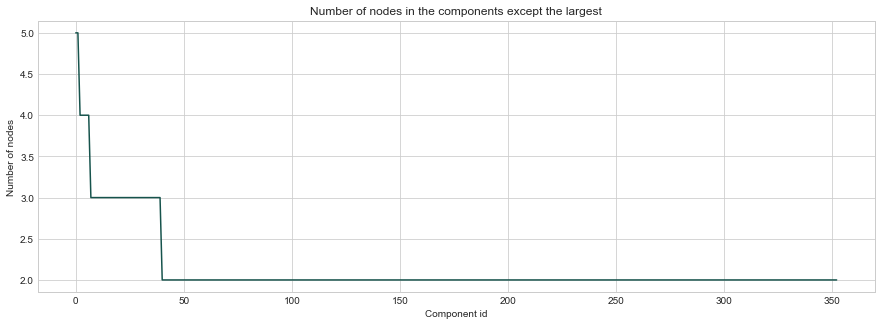

In [10]:
# Number of nodes in all components except the largest
nb_comp = []
for i in range(1,len(Gcc)):
    nb_comp.append(len(Gcc[i].nodes))
plt.figure(figsize=(15,5))
plt.plot(nb_comp);
plt.title('Number of nodes in the components except the largest');
plt.xlabel('Component id');
plt.ylabel('Number of nodes');

Since most components only contain two nodes and the largest contain 5. It's reasonable to continue with just the largest component.

The unweigted network G has 100518 nodes.
The unweigted network G has 1294160 edges.
The nodes in G has an average degree of 25.75.


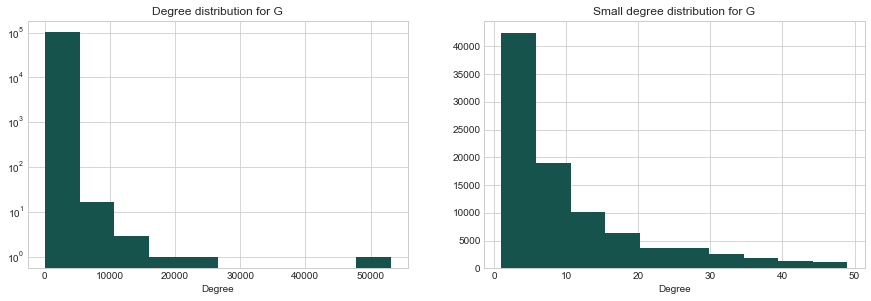

In [11]:
#keeping only the largest component
G = Gcc[0]

print('The unweigted network G has {} nodes.'.format(len(G.nodes())))
print('The unweigted network G has {} edges.'.format(G.size()))
print('The nodes in G has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G)).values()))/len(G.nodes())))

fig = plt.figure(1,figsize=(15,10))

#plotting degree distribution
degrees = np.array(list(dict(nx.degree(G)).values()))
plt.subplot(221)
plt.hist(degrees, log=True);
plt.title('Degree distribution for G');
plt.xlabel('Degree');

#plotting distribution for small degrees
small_degrees = degrees[degrees < 50]
plt.subplot(222)
plt.hist(small_degrees);
plt.title('Small degree distribution for G');
plt.xlabel('Degree');

Now we will try to detect communities in the network. If there are we will then try to analyze if communities share same music taste. To detect communities we use networkx which implements Louvain method to detect them.

In [13]:
genres = pickle.load(open('data_genre', 'rb'))

In [ ]:
comms = community.best_partition(G)
compareCommunitiesTaste(comms, genres)

In the plot above we present the repartition of the music jammed by user of the 15 largest communities. It can be observed that the communities are very similar in term of music taste. It means that the social network does not represent well the taste of the users. It also means that people tend to follow people for other reason than just the fact they share similar tastes.

#### Weighted social network
In the later analysis when we would like to observe how Jams propagate through a network. It could be important to consider how well connected two given nodes are and not just that they are simply connected. If two users interact many times we assume that they are also more likely to be influenced by each other. Therefore we will create a weighted graph where the edges' weights depend on the amount of times two users have liked each others jams.

In [12]:
# Merging likes and data
merge = likes.merge(data[['jam_id','user_id']],on='jam_id')
grouped = merge.groupby(['user_id_x','user_id_y']).count()
grouped.sort_values(by='jam_id',ascending=False).head()

jam_id
user_id_x                        user_id_y                               
8e01cba1a99a9eae7ffbb7bb76aac150 fd3292545fd8b2c8dcbdb86335052238    1723
a12e5a826d390a0a138c21841b8f34c7 fd3292545fd8b2c8dcbdb86335052238    1619
8eaf92d9023c44e657193e50f09e7725 fd3292545fd8b2c8dcbdb86335052238    1404
126932e6915c39fd6127c0c635461307 126932e6915c39fd6127c0c635461307    1307
dc87e7ab06a5aad596130c6966d2fe0c fd3292545fd8b2c8dcbdb86335052238    1163

Since the merge dataframe here is sorted by the number of likes form user_x to user_y, we can see that the maximum number of t likes are around a 1000, however most of them are far lower.

In [ ]:
G_w = G
for i in tqdm(range(len(merge))):
    if grouped.iloc[i].name[0] in G_w.nodes and grouped.iloc[i].name[1] in G_w.neighbors(grouped.iloc[i].name[0]):
            G_w[grouped.iloc[i].name[0]][grouped.iloc[i].name[1]]['weight'] += grouped.iloc[i]['jam_id']
nx.write_gpickle(G_w,'G_w')

In [14]:
# Load the graph
G_w = nx.read_gpickle('G_w')

The weigted network G_w has 100518 nodes.
The weigted network G_w has 1294160 edges.
The nodes in G_w has an average degree of 123.00.


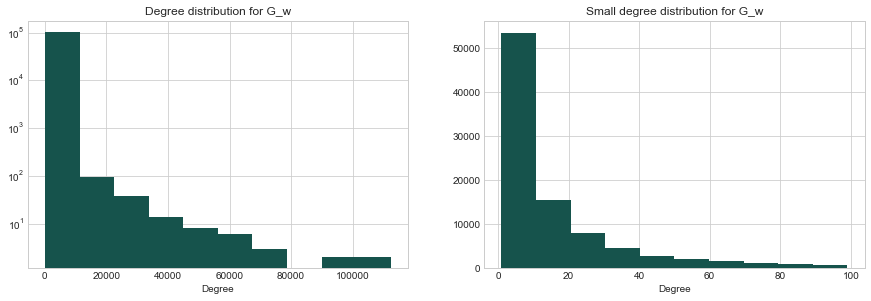

In [15]:

print('The weigted network G_w has {} nodes.'.format(len(G_w.nodes())))
print('The weigted network G_w has {} edges.'.format(G_w.size()))
print('The nodes in G_w has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_w,weight='weight')).values()))/len(G_w.nodes())))


fig = plt.figure(1,figsize=(15,10))

#pltotting degree distribution
degrees_w = np.array(list(dict(nx.degree(G_w,weight='weight')).values()))
plt.subplot(221)
plt.hist(degrees_w, log=True);
plt.title('Degree distribution for G_w');
plt.xlabel('Degree');

#plotting the small degrees
small_degrees_w = degrees_w[degrees_w < 100]
plt.subplot(222)
plt.hist(small_degrees_w);
plt.title('Small degree distribution for G_w');
plt.xlabel('Degree');

Again we see that even though the average degree is much higher than for the unweighted network most of the nodes still have very small degrees below 20. A few degrees have extremely high degrees around 100.000.

Again we take a look at the communities in the graphs and observe the taste of the main communities.

In [ ]:
comms = community.best_partition(G_w)
compareCommunitiesTaste(comms, genres)

In the weighted network we observe that the community seem to have more different music taste. It lead us to interpret as the fact that likes a person defines the type of music he could jam.

## Data Exploitation
Thanks to the data exploration we have been able to understand a lot about the My Jam social network. First it has been shown that working with the simple social graph would probably not lead to interesting conclusion. Indeed it seems that this network does not well represent any music taste. Then, using a weighted social network we have been able to show that music tastes are very probably more influenced by the liked you give to jam than just to the people you follow. 

It is why in the data exploitation we are interested in taking insurance about these primary conclusions. In order to be able to easily use signal processing over graph first we build a pruned social network. This graph is used first to look for any propagation of Jams over time in the network. Then we also use this graph to analyze if there is some spread of taste in the graph. Finally, in this part we construct an artificial graph which well reresent the music taste of people.

We first pruned the weighted social network.

In [16]:
#removing nodes with degree below 60
G_w_nodes = list(G_w.nodes())
G_w_degrees = G_w.degree(G_w_nodes,weight='weight')

for i in G_w_nodes:
    if G_w.degree[i] < 60:
        G_w.remove_node(i)
if not(nx.is_connected(G_w)):
    #keeping the largest connected component
    Gcc_w = sorted(nx.connected_component_subgraphs(G_w), key = len, reverse=True)
    Gcc_w = Gcc_w[0]
else:
    Gcc_w = G_w

print('The weigted network Gcc_grimes has {} nodes.'.format(len(Gcc_w.nodes())))
print('The weigted network Gcc_grimes has {} edges.'.format(Gcc_w.size()))
print('The nodes in Gcc_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(Gcc_w,weight='weight')).values()))/len(Gcc_w.nodes())))

The weigted network Gcc_grimes has 5342 nodes.
The weigted network Gcc_grimes has 386571 edges.
The nodes in Gcc_grimes has an average degree of 1596.18.


Using this network we observe the different propagation of music taste over the network. The music taste for each person in the graph is defined by the proportion of genre music the person has jammed. But first we look again for the community music tastes.

In [16]:
comms = community.best_partition(Gcc_w)
compareCommunitiesTaste(comms, genres)

NameError: name 'genres' is not defined

Communities seem to have very similar average taste, which is probably a sign that the pruned network does not really represent the music taste. We can confirm that by looking at signal processing over graph. We define the signals to be the proportion of each genre each person has jammed.

2018-01-22 16:50:49,462:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (5293 x 5293) may take some time.


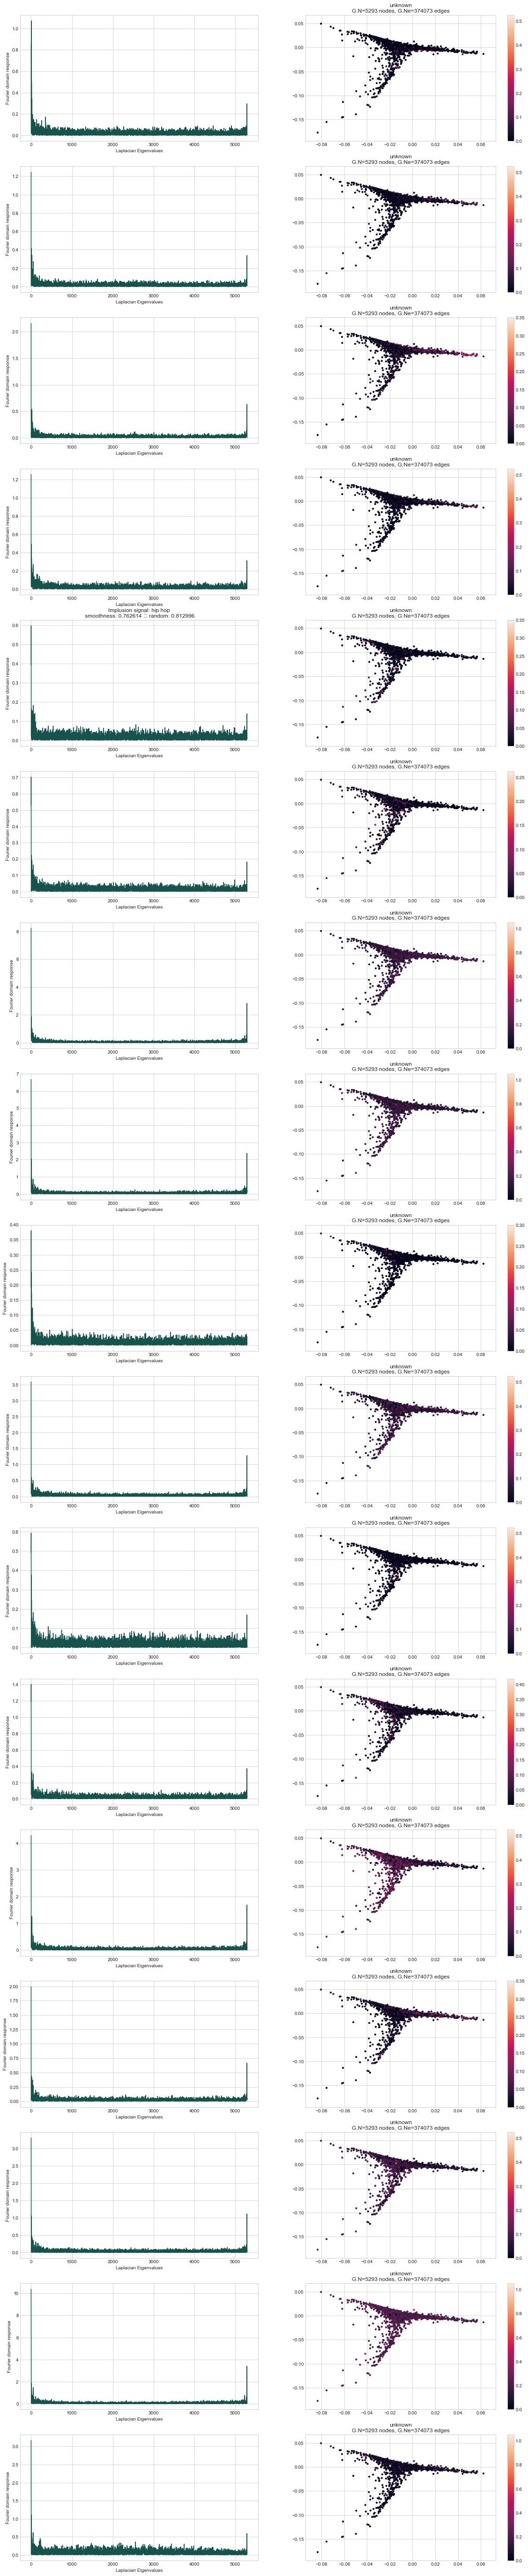

In [17]:
Gcc_w.remove_nodes_from(list(set(Gcc_w.nodes) - set(genres.index.values)))

#create graph
G_f = graphs.Graph(nx.adjacency_matrix(Gcc_w))
#compute fourier
G_f.compute_laplacian('normalized')
G_f.compute_fourier_basis()

signals = genres.loc[list(Gcc_w.nodes())].values

#plot the signals
fig, axes = plt.subplots(signals.shape[1], 2, figsize=(20, 100))

for i in range(signals.shape[1]):
    signal = signals[:, i]
    G_f.set_coordinates(G_f.U[:,1:3])
    G_f.plot_signal(signal,vertex_size=10, ax=axes[i, 1])
    #plt.axis([-1,1,-1,1])

    axes[i, 0].plot(np.abs(G_f.gft(signal)))
    axes[i, 0].set_xlabel('Laplacian Eigenvalues')
    axes[i, 0].set_ylabel('Fourier domain response')
    
    # Compute the signal smoothness with gradient
    smoothness = signal.T @ G_f.L @ signal / np.linalg.norm(signal)**2
    
    # Compute the suffles signal smoothness with gradient
    smoothness_rand = 0
    shuffled_signal = signal.copy()
    for i in range(5):
        np.random.shuffle(shuffled_signal)
        smoothness_rand += shuffled_signal.T @ G_f.L @ shuffled_signal / (5 * np.linalg.norm(shuffled_signal)**2)
    
    axes[i, 0].set_title('Implusion signal: %s\n smoothness: %f \t random: %f' % (genres.columns[i], smoothness,smoothness_rand))


As we can see none of the signal seems very smooth along the graph. Although the signal gradient is better then the signal applied at random we can conclude that the pruned weighted social network does not well represent music taste. 

Now that we have observed that purely social network does not well represent the taste of the people we would like to create an artificial network which represent well the taste of people. The idea is to use the likes of people to infer the genre of music they will probably Jam. A priori we cannot be sure that the person's likes really define its taste, indeed a person could like a Jam just because he likes the people who jammed it. And as we observed the social links does not well represent music taste. 

To construct the "likes" and analyze its accuracy to represent the Jam taste we select only the most active users.

In [18]:
data_likes = data.dropna(subset=['spotify_uri'])
data_likes = data_likes.groupby('user_id').count()
likes_grouped = likes.groupby('user_id').count()
data_likes = data_likes.merge(likes_grouped, left_index=True, right_index=True)

# Compute activity of each member.
data_likes = data_likes[['jam_id_x', 'jam_id_y']]
data_likes = data_likes[(data_likes['jam_id_x'] != 0) & (data_likes['jam_id_y'] != 0)]
data_likes['activity'] = data_likes['jam_id_x'] + data_likes['jam_id_y']

users = data_likes.sort_values('activity', ascending=False).iloc[:2000].index.values

likes_users = likes[likes.user_id.isin(list(users))]

In [20]:
genres_for_net = pickle.load(open('data_genre_not_grouped',"rb"))
likes_users = likes_users.merge(genres_for_net, on='jam_id')
likes_users.drop(columns=likes_users.columns[1:10], inplace=True)
likes_grouped = likes_users.groupby('user_id_x').sum()
likes_grouped = likes_grouped.divide(np.sum(likes_grouped.values, axis=1), axis=0)

In [21]:
distances = spatial.distance.squareform(spatial.distance.pdist(X=likes_grouped.values, metric='cosine'))
kernel_width = distances.mean() * 10
weights = np.exp(-np.square(distances/kernel_width**2)) - np.eye(len(distances))

In [22]:
NEIGHBORS = 50
# Find sorted indices for each row
sorted_row_idx = np.argsort(weights, axis=1)
for row in range(len(sorted_row_idx)):
    weights[row, sorted_row_idx[row, :-NEIGHBORS]] = 0

if sum(sum(abs(weights-weights.transpose()))) != 0:
    # Make W is symmetric
    bigger = weights.transpose() > weights
    weights = weights - weights*bigger + weights.transpose()*bigger
    #weights = (weights + weights.transpose())/2

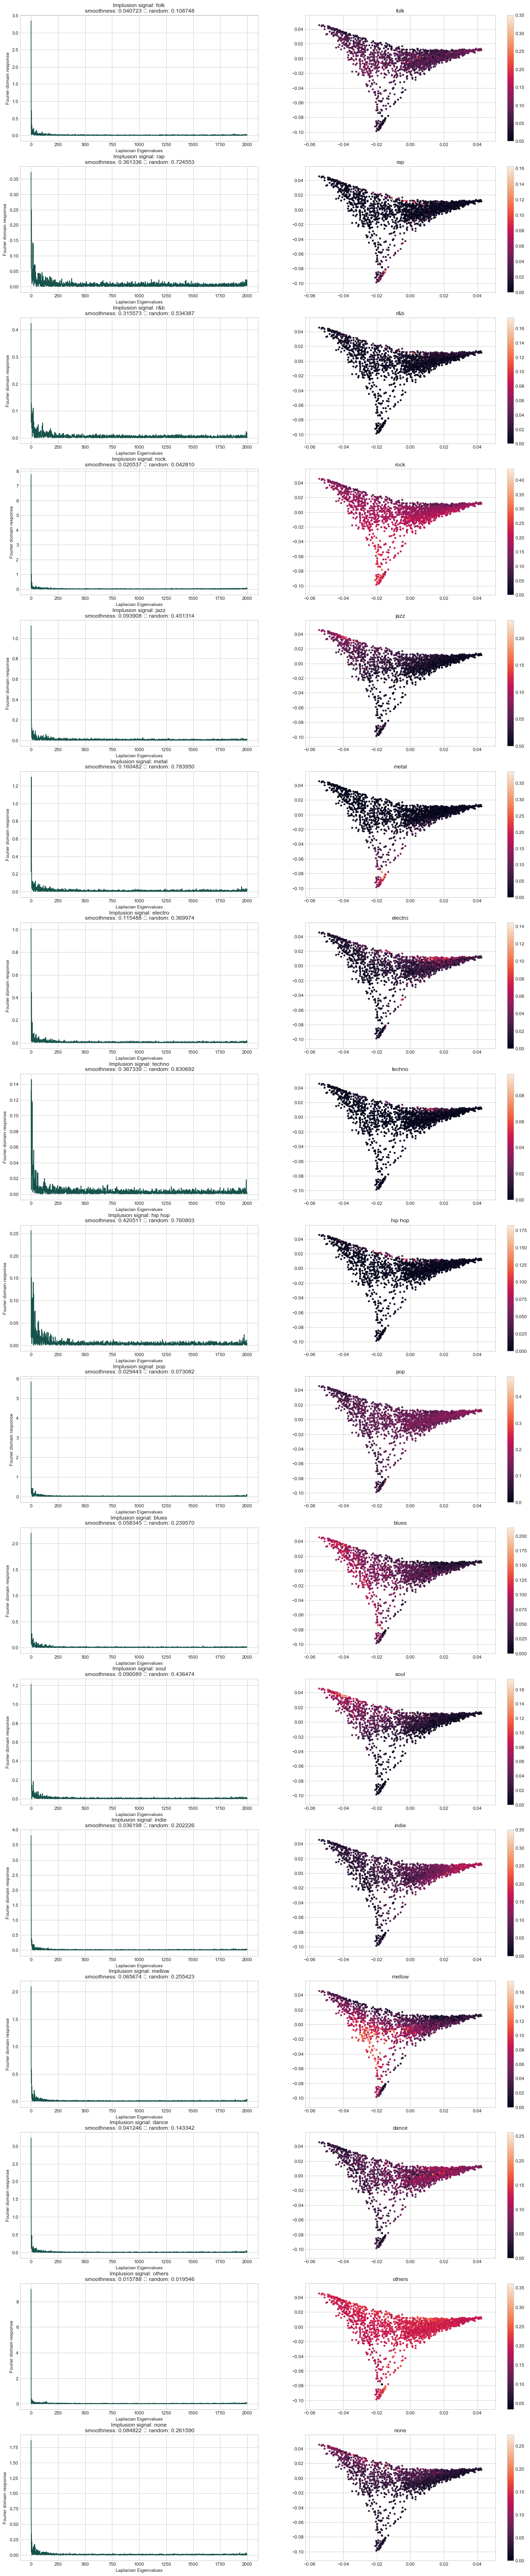

In [23]:
#create graph
G_likes = graphs.Graph(weights)
#compute fourier
G_likes.compute_laplacian('normalized')
G_likes.compute_fourier_basis()
#plot the signal
fig, axes = plt.subplots(len(likes_grouped.columns), 2, figsize=(20, 100))
i = 0
for column in likes_grouped.columns:
    signal = likes_grouped[column].values

    G_likes.set_coordinates(G_likes.U[:, [1, 2]])
    G_likes.plot_signal(signal,vertex_size=10, ax=axes[i, 1])

    axes[i, 0].plot(np.abs(G_likes.gft(signal)))
    axes[i, 0].set_xlabel('Laplacian Eigenvalues')
    axes[i, 0].set_ylabel('Fourier domain response')
    axes[i, 1].set_title(column)
    # Compute the signal smoothness with gradient
    smoothness = signal.T @ G_likes.L @ signal / np.linalg.norm(signal)**2

    # Compute the suffles signal smoothness with gradient
    smoothness_rand = 0
    for j in range(5):
        shuffled_signal = likes_grouped.sample(frac=1)[column].values
        smoothness_rand += shuffled_signal.T @ G_likes.L @ shuffled_signal / (5 * np.linalg.norm(shuffled_signal)**2)

    axes[i, 0].set_title('Implusion signal: %s\n smoothness: %f \t random: %f' % (column, smoothness,smoothness_rand))
    i += 1

Without surprise the signals are very smooth on this graph, indeed this graph has been built by the likes genre proximity between people and it is thus logical to obtain that these signal are smooth in it.

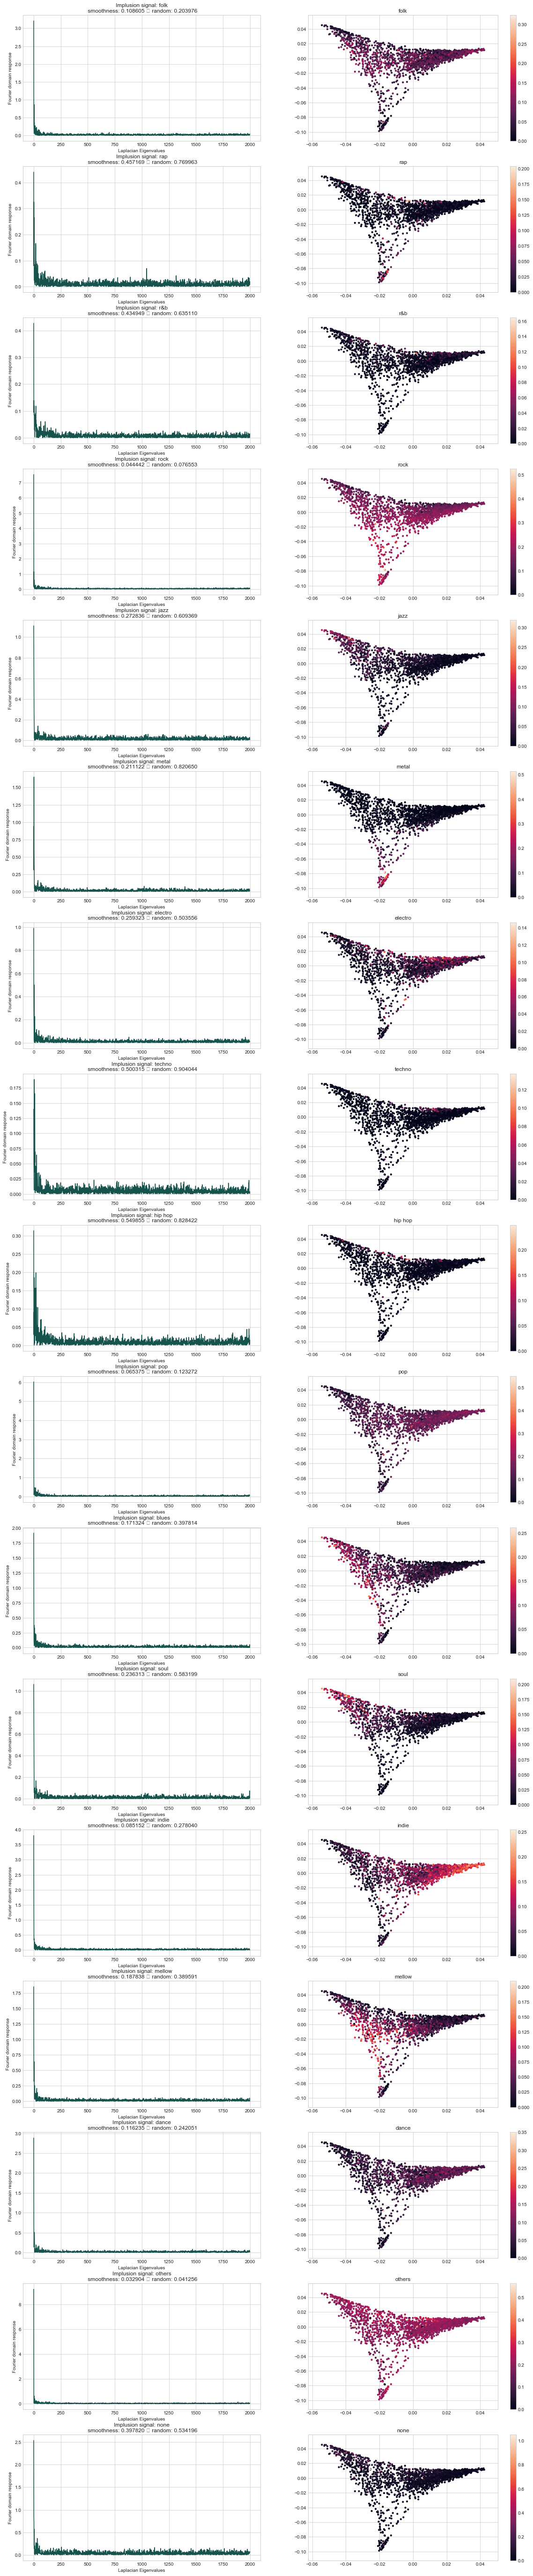

In [24]:
#create graph
G_likes = graphs.Graph(weights)
#compute fourier
G_likes.compute_laplacian('normalized')
G_likes.compute_fourier_basis()
#plot the signal
fig, axes = plt.subplots(len(genres.columns), 2, figsize=(20, 100))
i = 0

signals = genres.loc[list(likes_grouped.index.values)]
for column in likes_grouped.columns:
    signal = signals[column].values

    G_likes.set_coordinates(G_likes.U[:, [1, 2]])
    G_likes.plot_signal(signal,vertex_size=10, ax=axes[i, 1])

    axes[i, 0].plot(np.abs(G_likes.gft(signal)))
    axes[i, 0].set_xlabel('Laplacian Eigenvalues')
    axes[i, 0].set_ylabel('Fourier domain response')
    axes[i, 0].set_title('Implusion signal: %s' % column)
    axes[i, 1].set_title(column)
    # Compute the signal smoothness with gradient
    smoothness = signal.T @ G_likes.L @ signal / np.linalg.norm(signal)**2

    # Compute the suffles signal smoothness with gradient
    smoothness_rand = 0
    for j in range(5):
        shuffled_signal = signals.sample(frac=1)[column].values
        smoothness_rand += shuffled_signal.T @ G_likes.L @ shuffled_signal / (5 * np.linalg.norm(shuffled_signal)**2)
    axes[i, 0].set_title('Implusion signal: %s\n smoothness: %f \t random: %f' % (column, smoothness,smoothness_rand))

    i += 1

This time the signals are the genre proportion of the music jammed by persons. These signal are very smooth, although they are less smooth than the likes genre proportion we can still conclude that the network well represent the music taste of the users. From that we are able to conclude that the likes people give to jams well define the taste of the people, indeed using only this we are able to construct network in which the jam taste is well represented. It means that we could use this network to predict the type of song a person would jam, it also means that a recommender system for jam could be built based on both the jams and the likes. It could be very useful to push people who only likes jams to advice them some jam they could share.

# Appendix - What we tested but did not work

In this part we present the result we obtained when we analyzed the spread over time of the jams. The results are not very interesting because due to the large size of the network and the small size of people having shared a specific song. However since we take some time to carefully inspect that to be sure to not missout on something we would like to present here the result we found.

### The pruned network

We will now look at a pruned network where only nodes related to a given signal is kept. Later we will analyze the most relevant signals. We consider their relevance based on the amount of times the specific song has been jammed.

First we create a list containing the all the jammed songs sorted after the amount of times the song was jammed.

In [25]:
most_jammed = data[['jam_id','artist','title']].groupby(['artist','title']).count().sort_values(by='jam_id',ascending=False)

We then write a function to create any network with relevant weights.

### Example: The most jammed song

In [26]:
G_grimes = Create_network('Grimes','Oblivion', data, net, merge)
nx.write_gpickle(G_grimes,'G_grimes')

100%|██████████| 44414/44414 [00:04<00:00, 9905.66it/s] 


NameError: name 'merge' is not defined

In [ ]:
G_grimes = nx.read_gpickle('G_grimes')
print('The weigted network G_w has {} nodes.'.format(len(G_w.nodes())))
print('The weigted network G_w has {} edges.'.format(G_w.size()))
print('The nodes in G_w has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(G_w,weight='weight')).values()))/len(G_w.nodes())))

In [ ]:
#removing nodes with degree below 2
G_w_nodes = list(G_w.nodes())
G_w_degrees = G_w.degree(G_w_nodes,weight='weight')

for i in G_w_nodes:
    if G_w.degree[i] < 40:
        G_w.remove_node(i)
if not(nx.is_connected(G_w)):
    #keeping the largest connected component
    Gcc_w = sorted(nx.connected_component_subgraphs(G_w), key = len, reverse=True)
    Gcc_w = Gcc_w[0]
else:
    Gcc_w = G_w

print('The weigted network Gcc_grimes has {} nodes.'.format(len(Gcc_w.nodes())))
print('The weigted network Gcc_grimes has {} edges.'.format(Gcc_w.size()))
print('The nodes in Gcc_grimes has an average degree of {0:.2f}.'.format(sum(list(dict(nx.degree(Gcc_w,weight='weight')).values()))/len(Gcc_w.nodes())))

Now we define the signal.

In [ ]:
#create signal for Grimes Oblivion
data_grimes = create_signal(G_grimes,'Grimes','Oblivion', data)

In order to analyze the created signal we compute the Laplacian and fourier basis:

In [ ]:
#create graph
G_grimes_adj = nx.adjacency_matrix(G_grimes)
G_grimes_f = graphs.Graph(G_grimes_adj)

#compute fourier
G_grimes_f.compute_laplacian('normalized')
G_grimes_f.compute_fourier_basis()

In [ ]:
#plot the signal
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

signal = data_grimes['signal'].values
#G_grimes_f.set_coordinates(G_grimes_f.U[:,1:3])
G_grimes_f.set_coordinates()
G_grimes_f.plot_signal(signal,vertex_size=10, ax=axes[1])
plt.axis([-1,1,-1,1])

axes[0].plot(np.abs(G_grimes_f.gft(signal)))
axes[0].set_xlabel('Laplacian Eigenvalues')
axes[0].set_ylabel('Fourier domain response')
axes[0].set_title('Implusion signal')

Since most of the people have not shared the song it is difficult to evaluate the smoothness of the signal. So in order to try to answer the question: "Does jams spread over time?". We build specific network where every person in it has shared the same song, this network is still based on the social links between people. Then we evaluate if the signal of time is smooth or not. If yes we can conclude that the music really propagates through the network.

In [ ]:
fig, axes = plt.subplots(10, 2, figsize=(40, 30))
i = 0
for id, row in most_jammed.iloc[:10].iterrows():
    print(row.name[0:2])
    G_grimes_small = Create_network_jam(row.name[0], row.name[1], net, grouped, data)
    getInsightSongJam(row.name[0], row.name[1], fig, axes[i, :], G_grimes_small, data)
    i+=1

### Genre of songs community in different networks.

In [ ]:
#pickle.load('pickles/artists_ntds.pkl')
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )
#artist.artist_genres.astype(str, inplace=True)
all_genre = set()
genre_graph = nx.Graph()
for genre in artist.artist_genres.values:
    all_genre = all_genre.union(set(genre))
all_genre = list(all_genre)
genre_graph = nx.Graph()
genre_graph.add_nodes_from(all_genre)
for genres in tqdm(artist.artist_genres.values):
    for i in range(len(genres)):
        for j in range(i + 1, len(genres)):
            if genre_graph.has_edge(genres[i], genres[j]):
                genre_graph[genres[i]][genres[j]]['weight'] += 1
            else:
                genre_graph.add_edge(genres[i], genres[j], weight=1)


In [ ]:
plt.figure(figsize=(10,10))
weights = nx.adjacency_matrix(genre_graph).todense()
print(type(weights))
NEIGHBORS = 5
# Find sorted indices for each row
sorted_row_idx = np.argsort(weights, axis=1)
for row in range(len(sorted_row_idx)):
    weights[row, sorted_row_idx[row, :-NEIGHBORS]] = 0
plt.spy(weights,markersize=1);

if np.sum(np.abs(weights-weights.transpose())) != 0:
    # Make W is symmetric
    bigger = weights.transpose() > weights
    weights = weights - weights*bigger + weights.transpose()*bigger


In [ ]:
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )
genre_graph = nx.Graph()
all_genres = artist.artist_genres.values

for genre in tqdm(all_genre):
    artist[genre] = 0

for i in tqdm(range(len(all_genres))):
    genres = all_genres[i]
    artist.loc[i, genres] = 1

artist.columns

In [ ]:
genres_feature = artist.loc[:, artist.columns[2:]]
genre_f = genres_feature.transpose()
genre_f.head()

In [ ]:
artist = pickle.load( open( "pickles/artists_ntds.pkl", "rb" ) )

In [ ]:
all_genres = artist.artist_genres.values

all_genre = set()
genre_graph = nx.Graph()
for genre in artist.artist_genres.values:
    all_genre = all_genre.union(set(genre))
all_genre = list(all_genre)

for genre in tqdm(all_genre):
    artist[genre] = 0

for i in tqdm(range(len(all_genres))):
    genres = all_genres[i]
    artist.loc[i, genres] = 1

In [ ]:
#retrieve all major genres
genres = artist.columns
genres_other = set(artist.columns[2:])
todrop = []
for i in (["pop","rock","blues","jazz","hip hop","electro","indie","folk","rap","r&b","soul","metal","techno","mellow","dance",]):
    genre_new = [s for s in genres if i in s]
    artist_new = artist[genre_new].max(axis=1)
    artist[i] = artist_new
    todrop += genre_new
    genres_other = genres_other - (set(genre_new))
    if i in todrop:
        todrop.remove(i)
artist = artist.drop(todrop,axis=1)

In [ ]:
#create column for other gneres
artist_other = artist[list(genres_other)].max(axis=1)
artist['others'] = artist_other
artist = artist.drop(list(genres_other),axis=1)

#create column for artist with no genre
genres_red = artist.columns[2:]
artist_none = 1 - artist[genres_red].max(axis=1)
artist['none'] = artist_none

#Show the amount of songs in each genre
genre_f =artist.loc[:, artist.columns[2:]].transpose()
genre_total = genre_f.sum(axis=1)
genre_total.sort_values(ascending=False)

In [ ]:
#connecting artist_id's with the spotify_uri and through that with the full dataframe
songs = pickle.load(open('pickles/songs_ntds.pkl',"rb"))
data_genre = data.merge(songs, on='spotify_uri').merge(artist, on='artist_id')
#retrieving the fraction of jammed songs by one user within each genre
data_genre = data_genre.groupby('user_id').sum()
data_genre = (data_genre.T /data_genre.sum(axis=1)).T

pickle.dump(data_genre,open('data_genre',"wb"))

## Conclusion